# Plot Benchmark processes from P to Q

In [1]:
import torch
import torch.nn as nn
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tqdm import tqdm
from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
    get_test_input_samples
)

from eot_benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, compute_BW_by_gt_samples, calculate_cond_bw
)

## Hyper-Parameters

In [2]:
DIM=16
EPS=0.1
BATCH_SIZE=1024
GPU_DEVICE=0
N_STEPS=200
NUM_SAMPLES_PLOT=1000
SELECTED_IDX=[1,7,65,563,18,345]

## 1. Benchmark

In [3]:
input_sampler =get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device=f"cuda:{GPU_DEVICE}", download=True)

target_sampler =get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device=f"cuda:{GPU_DEVICE}", download=True)



Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /home/pvmokrov/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.8M/84.8M [00:01<00:00, 73.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /home/pvmokrov/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.8M/84.8M [00:01<00:00, 67.6MB/s]


## 2. Ground-Truth SDE

In [4]:
class GroundTruthSDE(nn.Module):
    
    def __init__(self, potential_params, eps, n_steps):
        super().__init__()
        probs, mus, sigmas = potential_params
        self.eps = eps
        self.n_steps = n_steps
        
        self.register_buffer("potential_probs", probs)
        self.register_buffer("potential_mus", mus)
        self.register_buffer("potential_sigmas", sigmas)

        
    def forward(self, x):
        
        trajectory = [x.cpu()]
        for i in tqdm(range(self.n_steps)):
            delta_t = 1/self.n_steps
            t = i/self.n_steps
            drift = self.get_drift(x, t)

            rand = np.sqrt(self.eps)*np.sqrt(delta_t)*torch.randn(*x.shape).to(x.device)

            x = (x + drift*delta_t + rand).detach()
            trajectory.append(x.cpu())
            
        return x, torch.stack(trajectory,dim=0)
    
    def get_drift(self, x_current, t):
        probs = self.potential_probs
        sigmas = self.potential_sigmas
        mus = self.potential_mus

        n_components, dim = mus.shape[0], mus.shape[1]
        identity = torch.diag(self.eps*(1.0-t)*torch.ones(dim))[None, :, :].expand(n_components, dim, dim).to(x_current.device)

        new_comp = MultivariateNormal(loc=mus, covariance_matrix=(sigmas) + identity)
        phi_t_distr = MixtureSameFamily(Categorical(self.potential_probs), new_comp)
        
        x_current.requires_grad = True
        log_p = phi_t_distr.log_prob(x_current)

        return self.eps*torch.autograd.grad(log_p, x_current, grad_outputs=torch.ones(x_current.shape[0]).to(x_current.device))[0]

In [5]:
mus = target_sampler.conditional_plan.potential_mus
probs = target_sampler.conditional_plan.potential_probs
sigmas = target_sampler.conditional_plan.potential_sigmas

new_comp = MultivariateNormal(loc=mus, covariance_matrix=sigmas)
true_potential = MixtureSameFamily(Categorical(probs), new_comp)
# EPSILON*true_potential.log_prob(X_samples)

potential_params = (probs, mus, sigmas)

model = GroundTruthSDE(potential_params, EPS, N_STEPS)

In [6]:
input_samples = input_sampler.sample(NUM_SAMPLES_PLOT)
target_samples = target_sampler.sample(NUM_SAMPLES_PLOT)
_,traj_true = model(input_samples)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 245.80it/s]


In [7]:
traj_true.shape

torch.Size([201, 1000, 16])

## 3. PCA plot of trajectories

In [8]:
pca = PCA(n_components=2).fit(target_samples.cpu().numpy())
target_emb = pca.transform(target_samples.cpu().numpy())
input_emb = pca.transform(input_samples.detach().cpu().numpy())

pca_traj = []
for i in range(N_STEPS+1):
    pca_traj.append(pca.transform(traj_true[i,:,:].cpu().numpy()))
pca_traj_emb = np.stack(pca_traj,axis=0)

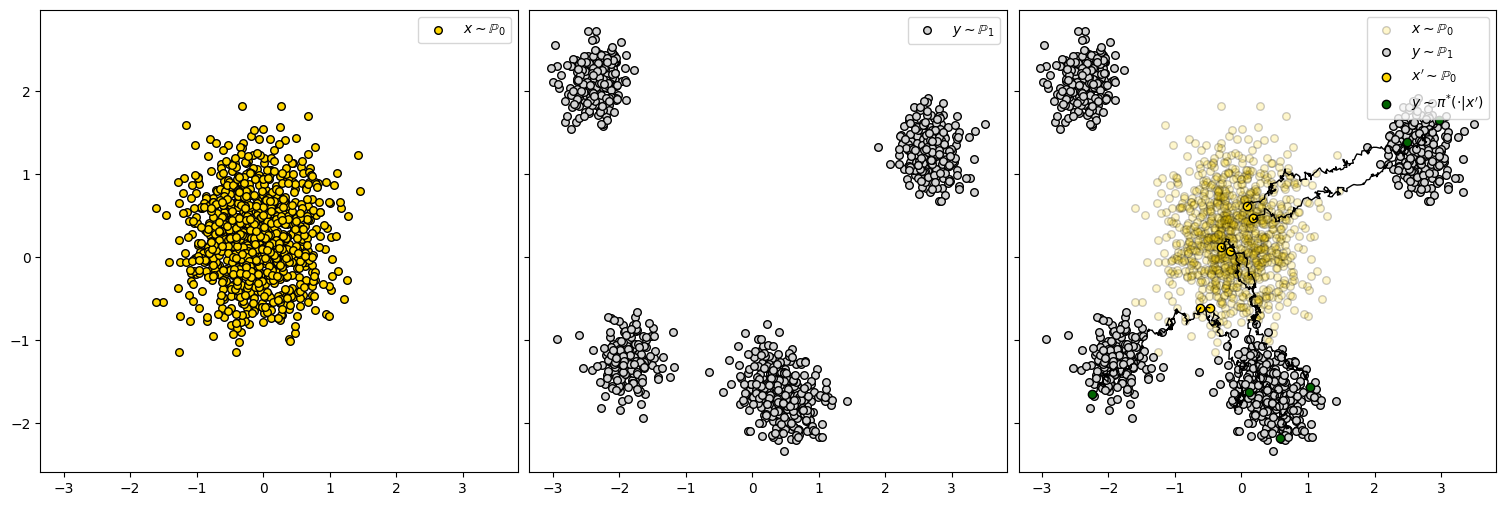

In [9]:
fig,axes = plt.subplots( 1, 3,figsize=(15,5),squeeze=True,sharex=True,sharey=True)

axes[0].scatter( input_emb[:,0], input_emb[:,1], c="gold", edgecolor = 'black',
                label = r'$x \sim \mathbb{P}_{0}$', s =30)

axes[1].scatter( target_emb[:,0],target_emb[:,1], c="lightgray", edgecolor = 'black',
                label = r'$y\sim \mathbb{P}_{1}$', s =30)

 
axes[2].scatter( input_emb[:,0], input_emb[:,1], c="gold", edgecolor = 'black',
                        label = r'$x \sim \mathbb{P}_{0} $', s =30,alpha=0.2)
axes[2].scatter( target_emb[:,0], target_emb[:,1], c="lightgray", edgecolor = 'black',
                        label = r'$y \sim \mathbb{P}_{1}$', s =30,alpha=1)

for j in SELECTED_IDX:
    axes[2].plot(pca_traj_emb[:, j, 0], pca_traj_emb[:, j, 1],linewidth=1,color='black')  
    axes[2].scatter(pca_traj_emb[0, j, 0], pca_traj_emb[0, j, 1],edgecolor='black',color='gold',
                    label=r"$x' \sim \mathbb{P}_{0}$" if j==SELECTED_IDX[-1] else None)
    axes[2].scatter(pca_traj_emb[-1, j, 0], pca_traj_emb[-1, j, 1],edgecolor='black', color='darkgreen',zorder=2,
                    label=r"$y \sim  \pi^{*}(\cdot|x')$" if j==SELECTED_IDX[-1] else None)

    
axes[0].legend();axes[1].legend();axes[2].legend(loc='upper right')
fig.tight_layout(pad=0.5)

## 4. KL computation

### 4.1 Forward KL

In [10]:
def integrate(values, times):
    deltas = (times[1:] - times[:-1])
    #print(deltas.shape)
    return (values*deltas[None, :]).sum(dim = 1)

In [11]:
kl_div_fwd = []
eval_drift_t = []
true_drift_t = []

for i in tqdm(range(N_STEPS)):

    t = i/N_STEPS
    samples = traj_true[i,:,:].to("cuda:0")

    eval_drift = torch.zeros_like(samples)
    eval_drift_t.append(eval_drift)
     
    
    t = i/N_STEPS
    true_drift = model.get_drift(samples.to("cuda:0"),t ).cpu()
    true_drift_t.append(true_drift)

    kl_div_fwd.append(0.5/EPS*torch.mean(torch.norm(true_drift.to("cuda:0") - eval_drift.to("cuda:0"),dim=1,p=2)**2).cpu())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 268.09it/s]


In [12]:
eval_drift = torch.stack(eval_drift_t,dim=0).cpu() #[T,B,D]
true_drift = torch.stack(true_drift_t,dim=0).cpu() #[T,B,D]
norm = torch.norm( eval_drift - true_drift ,p=2,dim=2)**2 #[T,B]
times = torch.linspace(0,1.,201)
integral = integrate(norm.view(-1,times.shape[0] - 1),times)
kl_forward = 0.5/EPS*integral.mean()
kl_forward

tensor(46.3916)

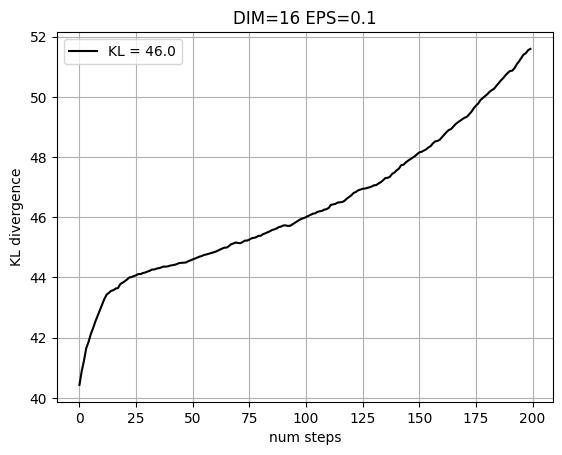

In [13]:
plt.plot(kl_div_fwd,color='black',label=f'KL = {np.round(kl_forward.item())}')
plt.title(f"DIM={DIM} EPS={EPS}");
plt.xlabel("num steps")
plt.ylabel("KL divergence");
plt.grid();
plt.legend();

### 4.2 reverse KL 

In [14]:
x = input_samples
traj = [x]
for i in range(N_STEPS):
    x = x + EPS*math.sqrt(1/N_STEPS)*torch.randn_like(x)
    traj.append(x)

In [15]:
traj = torch.stack(traj,dim=0)

In [16]:
kl_div_rev = []
eval_drift_t = []
true_drift_t = []

for i in tqdm(range(N_STEPS)):

    t = i/N_STEPS
    samples = traj[i,:,:].to("cuda:0")

    eval_drift = torch.zeros_like(samples)
    eval_drift_t.append(eval_drift)
     
    
    t = i/N_STEPS
    true_drift = model.get_drift(samples.detach().to("cuda:0"),t ).cpu()
    true_drift_t.append(true_drift)

    kl_div_rev.append(0.5/EPS*torch.mean(torch.norm(true_drift.to("cuda:0") - eval_drift.to("cuda:0"),dim=1,p=2)**2).cpu())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 261.23it/s]


In [17]:
eval_drift = torch.stack(eval_drift_t,dim=0).cpu() #[T,B,D]
true_drift = torch.stack(true_drift_t,dim=0).cpu() #[T,B,D]
norm = torch.norm( eval_drift - true_drift ,p=2,dim=2)**2 #[T,B]
times = torch.linspace(0,1.,201)
integral = integrate(norm.view(-1,times.shape[0] - 1),times)
kl_rev = 0.5/EPS*integral.mean()
kl_rev

tensor(108.5353)

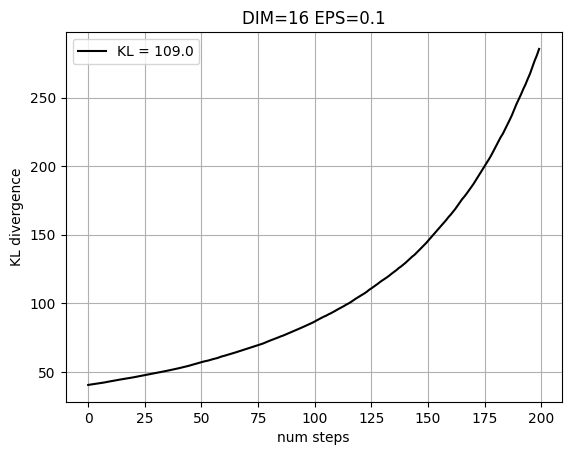

In [18]:
plt.plot(kl_div_rev,color='black',label=f'KL = {np.round(kl_rev.item())}')
plt.title(f"DIM={DIM} EPS={EPS}");
plt.xlabel("num steps")
plt.ylabel("KL divergence");
plt.grid();
plt.legend();